# Converting raw fitness data to BinaryMap object

In this notebook, I analyze the raw data reported in Olson et al. (2014) - *A Comprehensive Biophysical Description of Pairwise Epistasis throughout an Entire Protein Domain*. This paper assays GB1 fitness as binding affinity for IgG Fc, characterized using mRNA display. The authors create all single and and double mutations in GB1 and measure their resulting fitness. Raw data is reported as read counts before and after selection.\
\
Here, I read in the raw data, use the read couunts to calculate fitness as described in the paper, and format the dataframes such that they can be turned into BinaryMap objects for downstream epistasis modeling. BinaryMap is part of the `dms_variants` package developed by the Bloom Lab, and more information can be found [here](https://jbloomlab.github.io/dms_variants/dms_variants.binarymap.html). The output of this notebook is two BinaryMap objects describing fitness of single and double mutants, respectively.

In [2]:
import pandas as pd
import numpy as np

import dms_variants.binarymap
import dms_variants.globalepistasis

### Basic reformatting of raw data

In [3]:
raw_fitness = pd.read_csv('../data/olson_gb1_fitness.csv', header=1)
raw_fitness.head()

/Users/frances/anaconda3/envs/dms/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Mut1 WT amino acid,Mut1 Position,Mut1 Mutation,Mut2 WT amino acid,Mut2 Position,Mut2 Mutation,Input Count,Selection Count,Mut1 Fitness,Mut2 Fitness,...,Unnamed: 11,WT amino acid,Position,Mutation,Input Count.1,Selection Count.1,Unnamed: 17,Unnamed: 18,Input Count.2,Selection Count.2
0,Q,2,A,Y,3,A,173,33,1.518,0.579,...,NaN,Q,2.0,A,14663.0,38476.0,NaN,NaN,1759616.0,3041819.0
1,Q,2,A,Y,3,C,18,8,1.518,0.616,...,NaN,Q,2.0,C,13001.0,23023.0,NaN,NaN,NaN,NaN
2,Q,2,A,Y,3,D,66,2,1.518,0.010,...,NaN,Q,2.0,D,11488.0,18085.0,NaN,NaN,NaN,NaN
3,Q,2,A,Y,3,E,72,1,1.518,0.009,...,NaN,Q,2.0,E,9501.0,15629.0,NaN,NaN,NaN,NaN
4,Q,2,A,Y,3,F,69,168,1.518,1.054,...,NaN,Q,2.0,F,4770.0,13332.0,NaN,NaN,NaN,NaN


Look at df setup

In [4]:
raw_fitness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 535917 entries, 0 to 535916
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Mut1 WT amino acid  535917 non-null  object 
 1   Mut1 Position       535917 non-null  int64  
 2   Mut1 Mutation       535917 non-null  object 
 3   Mut2 WT amino acid  535917 non-null  object 
 4   Mut2 Position       535917 non-null  int64  
 5   Mut2 Mutation       535917 non-null  object 
 6   Input Count         535917 non-null  int64  
 7   Selection Count     535917 non-null  int64  
 8   Mut1 Fitness        535917 non-null  float64
 9   Mut2 Fitness        535917 non-null  float64
 10  Unnamed: 10         0 non-null       float64
 11  Unnamed: 11         0 non-null       float64
 12  WT amino acid       1045 non-null    object 
 13  Position            1045 non-null    float64
 14  Mutation            1045 non-null    object 
 15  Input Count.1       1045 non-null 

Split into usable dataframes / variables - fitness_m2 for double mutants, fitness_m1 for single

In [5]:
# split into separate dfs for single and double mutants
fitness_m2 = raw_fitness.iloc[:, :10]
fitness_m1 = raw_fitness.iloc[:, 12:17].dropna(how='all')

# pull out variables wt_input and wt_sele
wt_input = int(raw_fitness.iloc[0, 19])
wt_sele = int(raw_fitness.iloc[0, 20])

Concatenate substitution info into one 'aa_substitutions' column and clean up the data

In [6]:
# create new column
fitness_m2['aa_substitutions'] = (
    fitness_m2['Mut1 WT amino acid'].astype(str) + fitness_m2['Mut1 Position'].astype(str) + 
    fitness_m2['Mut1 Mutation'].astype(str) + ' ' + 
    fitness_m2['Mut2 WT amino acid'].astype(str) + fitness_m2['Mut2 Position'].astype(str) + 
    fitness_m2['Mut2 Mutation'].astype(str)
)

# drop redundant raw AA columns
fitness_m2.drop(fitness_m2.columns[0:6], axis=1, inplace=True)

# shift aa_substitutions to index 0
cols = list(fitness_m2.columns)
cols = cols[-1:] + cols[:-1]
fitness_m2 = fitness_m2[cols]

# rename headers
fitness_m2.rename(columns={'Input Count':'input_count', 'Selection Count':'sele_count', 
                          'Mut1 Fitness':'mut1_fitness','Mut2 Fitness':'mut2_fitness'}, 
                  inplace=True)

# change counts to numeric
num_cols = ['input_count', 'sele_count', 'mut1_fitness', 'mut2_fitness']
fitness_m2[num_cols] = fitness_m2[num_cols].astype(np.float64)

fitness_m2.head()

,aa_substitutions,input_count,sele_count,mut1_fitness,mut2_fitness
0,Q2A Y3A,173.0,33.0,1.518,0.579
1,Q2A Y3C,18.0,8.0,1.518,0.616
2,Q2A Y3D,66.0,2.0,1.518,0.010
3,Q2A Y3E,72.0,1.0,1.518,0.009
4,Q2A Y3F,69.0,168.0,1.518,1.054


In [7]:
# Repeat for fitness_m1:

fitness_m1['aa_substitutions'] = (fitness_m1['WT amino acid'].astype(str) + 
    fitness_m1['Position'].astype(int).astype(str) + fitness_m1['Mutation'].astype(str)
)

# drop redundant raw AA columns
fitness_m1.drop(fitness_m1.columns[0:3], axis=1, inplace=True)

# shift aa_substitutions to index 0
cols = list(fitness_m1.columns)
cols = cols[-1:] + cols[:-1]
fitness_m1 = fitness_m1[cols]

# rename headers
fitness_m1.rename(columns={'Input Count.1':'input_count', 'Selection Count.1':'sele_count'}, 
                  inplace=True)

# change counts to numeric
num_cols = ['input_count', 'sele_count']
fitness_m1[num_cols] = fitness_m1[num_cols].astype(np.int)

fitness_m1.head()

,aa_substitutions,input_count,sele_count
0,Q2A,14663,38476
1,Q2C,13001,23023
2,Q2D,11488,18085
3,Q2E,9501,15629
4,Q2F,4770,13332


### Calculating functional scores for mutants from counts

Calculate single-mutant and double-mutant fitness from raw count data, defined as:\
\
W = ((mutant selection count) / (wt selection count))  /  ((mutant input) / (wt input))\
\
In other words, fitness W is the post-selection frequency of the mutant relative to wildtype. Label fitness values as 'func_score' to align with BinaryMap input.

In [8]:
def calc_fitness(df):
    df = df.assign(func_score = lambda x: (x['sele_count'] / wt_sele) / 
                      (x['input_count'] / wt_input))
    return df

In [9]:
fitness_m1 = calc_fitness(fitness_m1)
fitness_m2 = calc_fitness(fitness_m2)
fitness_m2.head()

,aa_substitutions,input_count,sele_count,mut1_fitness,mut2_fitness,func_score
0,Q2A Y3A,173.0,33.0,1.518,0.579,0.110345
1,Q2A Y3C,18.0,8.0,1.518,0.616,0.257100
2,Q2A Y3D,66.0,2.0,1.518,0.010,0.017530
3,Q2A Y3E,72.0,1.0,1.518,0.009,0.008034
4,Q2A Y3F,69.0,168.0,1.518,1.054,1.408461


In [21]:
fitness_m2_group = fitness_m2.groupby('aa_substitutions')
fitness_m2_group.head()

,aa_substitutions,input_count,sele_count,mut1_fitness,mut2_fitness,func_score
0,Q2A Y3A,173.0,33.0,1.518,0.579,0.110345
1,Q2A Y3C,18.0,8.0,1.518,0.616,0.257100
2,Q2A Y3D,66.0,2.0,1.518,0.010,0.017530
3,Q2A Y3E,72.0,1.0,1.518,0.009,0.008034
4,Q2A Y3F,69.0,168.0,1.518,1.054,1.408461
...,...,...,...,...,...,...
535912,E56Y T55R,462.0,139.0,0.190,0.941,0.174043
535913,E56Y T55S,317.0,84.0,0.190,0.840,0.153287
535914,E56Y T55V,335.0,77.0,0.190,0.669,0.132963
535915,E56Y T55W,148.0,28.0,0.190,0.798,0.109441


In [24]:
q2a_list = fitness_m2.index[fitness_m2['aa_substitutions'] == 'Q2A Y3D'].tolist()

In [25]:
q2a_list

[2]

### Converting to BinaryMap objects

Note that we're missing a few columns that dms_variants.BinaryMap usually expects as inputs: 
* pre_count_wt
* post_count_wt
* n_aa_substitutions
* library
* func_score_var

Any columns that are not inputted are automatically set to a parameter of zero, and the corresponding attribute is set to *None*.

In [9]:
m1_bmap = dms_variants.binarymap.BinaryMap(fitness_m2, 
                                           n_pre_col='input_count', 
                                           n_post_col='sele_count')

m2_bmap = dms_variants.binarymap.BinaryMap(fitness_m2, 
                                           n_pre_col='input_count', 
                                           n_post_col='sele_count')

## Check transpose function to test number of variants for each substitution

In [13]:
import collections

def transpose_of_aa_substitutions(aa_func_scores):
    transpose = collections.defaultdict(list)
    
    for i, aa_substitutions in aa_func_scores['aa_substitutions'].astype(str).items():
        for aa_substitution in aa_substitutions.split():
            transpose[aa_substitution].append(i)
    
    return transpose

In [18]:
fitness_m2_short = fitness_m2.drop(fitness_m2.columns[3:5], axis=1)
fitness_comb = pd.concat([fitness_m2_short, fitness_m1], axis=0)
fitness_comb.head()

,aa_substitutions,input_count,sele_count
0,Q2A Y3A,173.0,33.0
1,Q2A Y3C,18.0,8.0
2,Q2A Y3D,66.0,2.0
3,Q2A Y3E,72.0,1.0
4,Q2A Y3F,69.0,168.0


In [19]:
transpose_of_aa_substitutions(fitness_comb.head())

defaultdict(list,
            {'Q2A': [0, 1, 2, 3, 4],
             'Y3A': [0],
             'Y3C': [1],
             'Y3D': [2],
             'Y3E': [3],
             'Y3F': [4]})

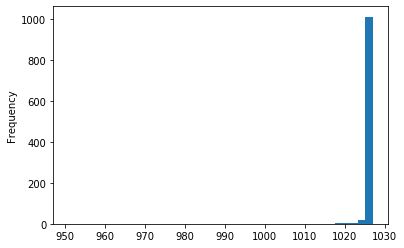

In [15]:
aa_transpose = transpose_of_aa_substitutions(fitness_comb)
pd.Series([len(v) for v in aa_transpose.values()]).plot.hist(bins=40)